## Perfil de carga diario del lugar en intervalos de una hora

La energía consumida en un dia es  11.3305 [kWh]


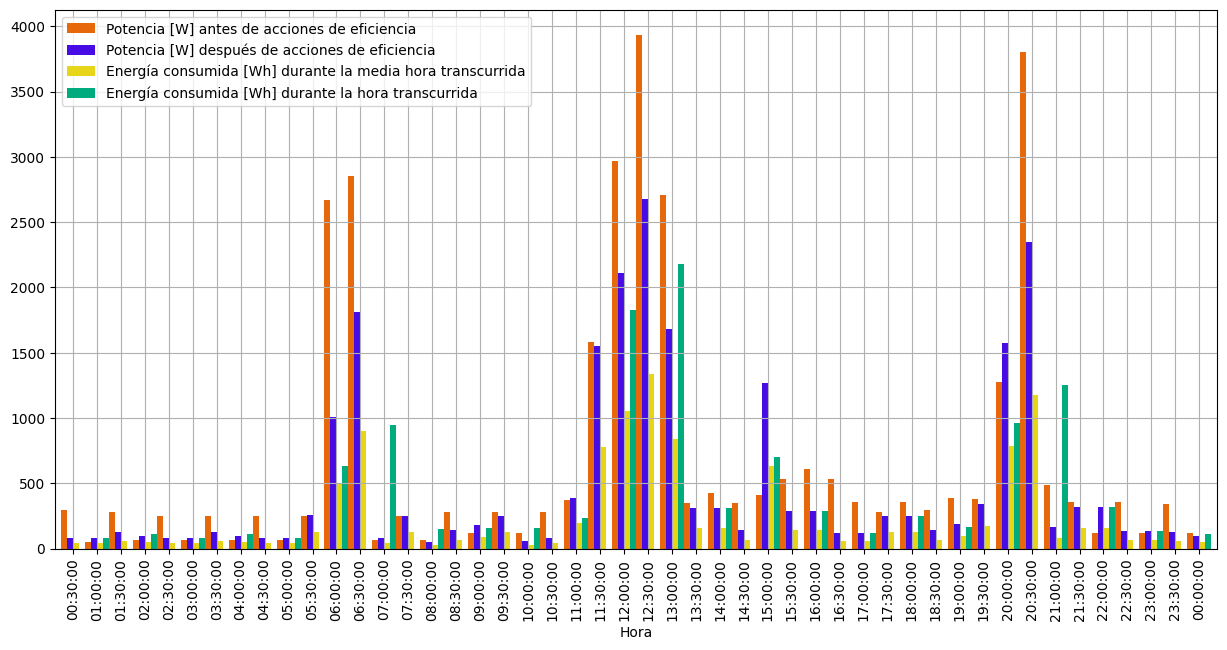

In [1]:
from numpy import trapz
import pandas as pd
from matplotlib.pyplot import *

potencia_equipos = {
    'Computador_1' : 40,
    'Nevera_1' : 80,
    'Bombillo_1' : 12,
    'Bombillo_2' : 12,
    'Bombillo_3' : 12,
    'Bombillo_4' : 12,
    'Bombillo_5' : 12,
    'Estufa_de_induccion_1' : 1300,
    'Estufa_de_induccion_2' : 1300,
    'Estufa_de_induccion_3' : 1300,
    'Televisor_1' : 60,
    'Lavadora_1' : 250,
    'Horno_tostador_1' : 800,
    'Aire_acondicionado_1' : 250,
    'bomba_de_agua_1' : 0,
}

df_P = pd.read_excel('data.xlsx', index_col='Hora', sheet_name='Pdt' )

fig, ax = subplots(figsize=(15,7))
df_P.plot( kind='bar', ax=ax,color=['#E6680B','#470BE6', '#E6D519', '#00AB7E' ], width=1 )
ax.legend(["Potencia [W] antes de acciones de eficiencia","Potencia [W] después de acciones de eficiencia", "Energía consumida [Wh] durante la media hora transcurrida","Energía consumida [Wh] durante la hora transcurrida"]);
ax.grid(True)

E_dia = trapz( df_P['Potencia'], dx=0.5 ) 
print( 'La energía consumida en un dia es ', E_dia / 1000 , '[kWh]' )


## Radiación solar

El mayor valor de energía disponible al dia es de  7.467  en  09-17
El menor valor de energía disponible al dia es de  1.972  en  04-30


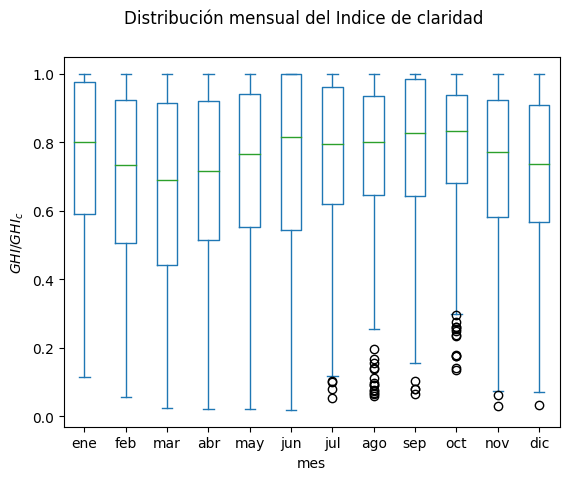

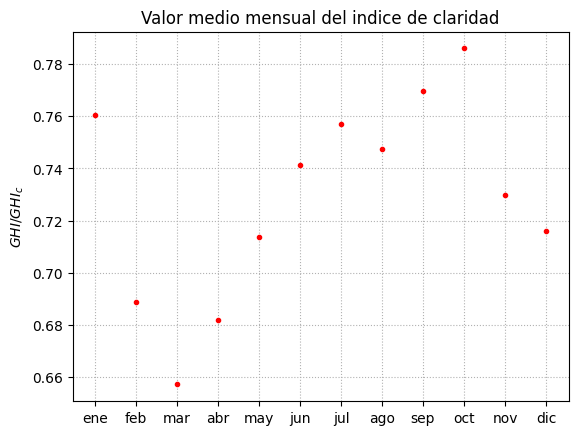

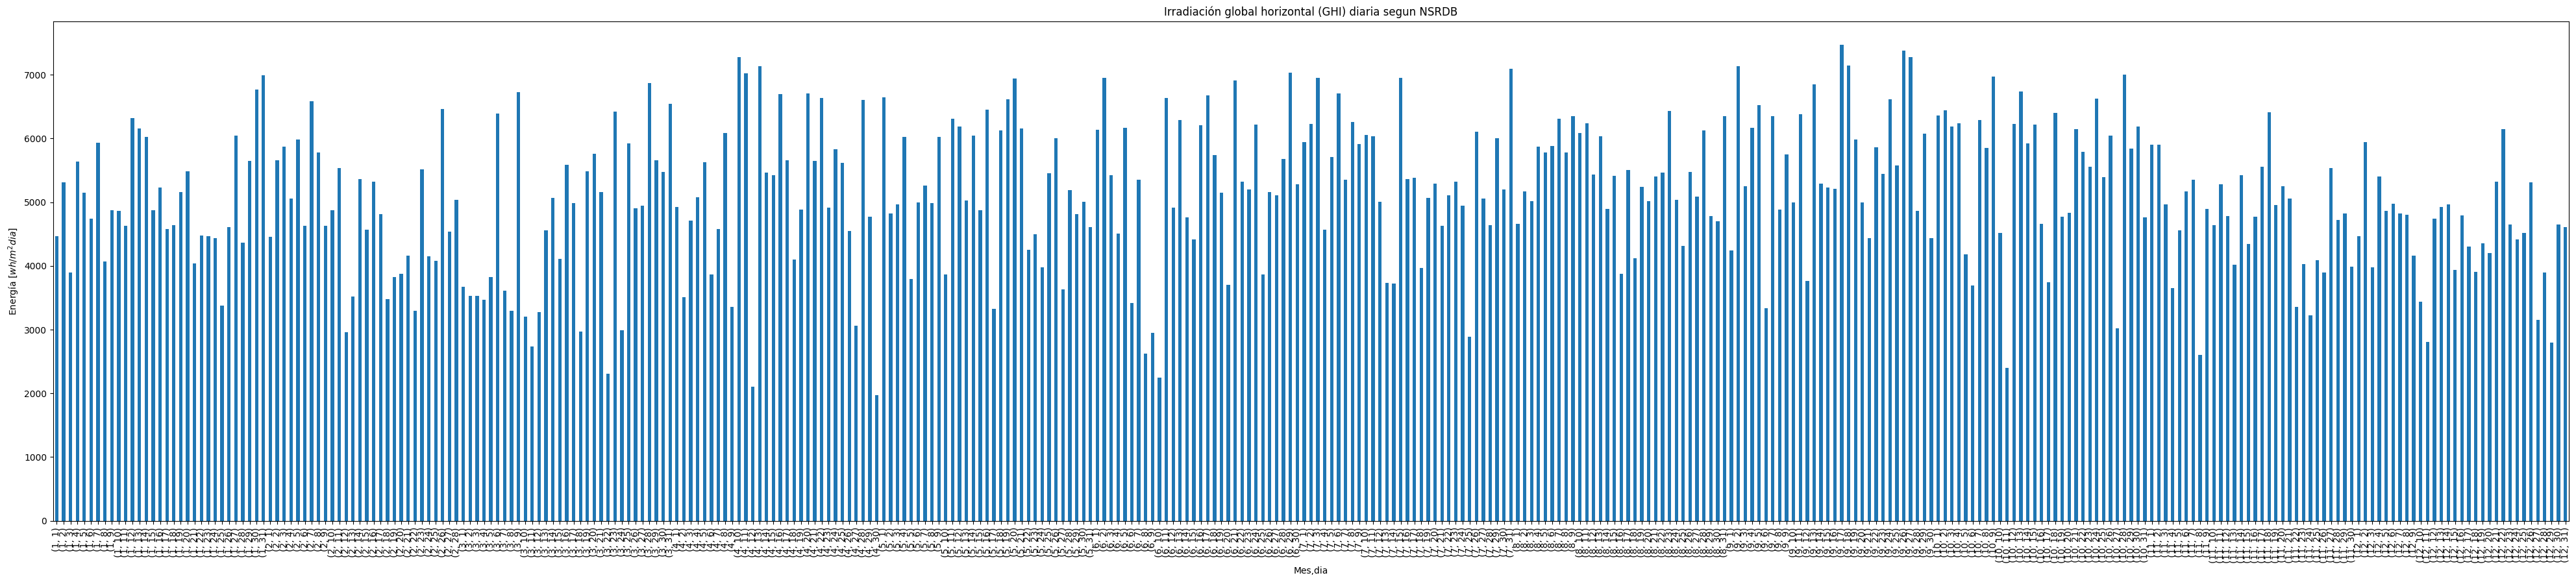

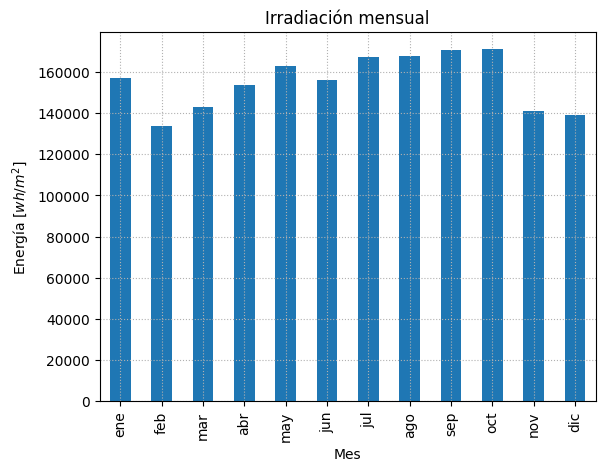

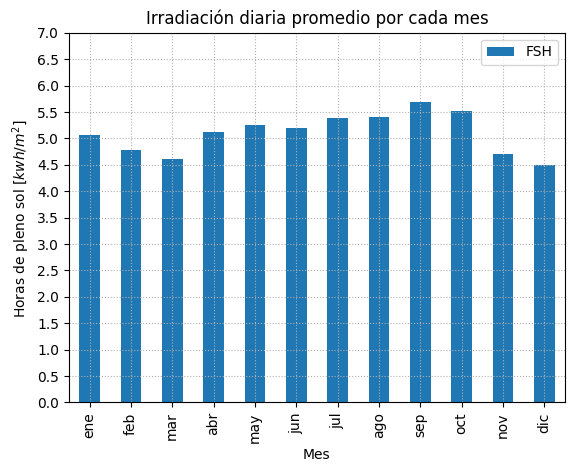

In [2]:
from numpy import std, mean, arange
import datetime

month_names = ['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic']

df_irradiancia = pd.read_excel('data.xlsx', sheet_name='NSRDB', usecols=['Month','Day','Hour','Minute','Clearsky DHI','Clearsky GHI','DHI','GHI'] )
df_irradiancia.columns = [c.replace(' ', '_') for c in df_irradiancia.columns]
mes_ = []
dia_ = []
fsh_dir = []
fsh_dif = []
fsh_ghi = []
dates = []
K_t = []
sigma = []
for mes in df_irradiancia['Month'].unique():
    month = df_irradiancia.query(f'Month == {mes}')
    k_t =  [ i.GHI / i.Clearsky_GHI for i in month.itertuples() if i.Clearsky_GHI != 0 ] 
    K_t.append( mean(k_t) )
    sigma.append( std(k_t) )
    for dia in df_irradiancia.query(f'Month == {mes}')['Day'].unique():
        mes_.append(mes)
        dia_.append(dia)
        day = df_irradiancia.query(f'Month == {mes} and Day == {dia}')
        E_dif = trapz( day['DHI'], dx=1 ) / 1000
        E_ghi = trapz( day['GHI'], dx=1 ) / 1000
        E_dir = E_ghi - E_dif
        fsh_ghi.append( E_ghi )
        fsh_dir.append( E_dir )
        fsh_dif.append( E_dif )
        dates.append( datetime.datetime(year=2021,month=mes,day=dia) )
        
fsh = pd.DataFrame(data = { 'Mes': mes_, 'Dia':dia_, 'Irradiancia difusa':fsh_dif, 'Irradiancia directa':fsh_dir } )
fshGHI = pd.DataFrame( data={'Mes': mes_,'FSH':fsh_ghi }, index=dates )

df_irradiancia['K_t'] = ( df_irradiancia['GHI'] / df_irradiancia['Clearsky_GHI'] )

df_irradiancia.plot.box(column='K_t', by='Month', xlabel='mes', ylabel='$GHI/GHI_c$')
suptitle('Distribución mensual del Indice de claridad')
title('')
xticks([1,2,3,4,5,6,7,8,9,10,11,12],month_names)

# Graficando mes a mes
# for mes in fsh['Mes'].unique():
#     ax = fsh.query(f'Mes == {mes}').plot.bar( x='Dia' ,y=['Irradiancia difusa','Irradiancia directa'], stacked=True, figsize=(20,6) )
#     mes_str = datetime.datetime(year=2022, month=mes, day=1).strftime("%B")
#     title(mes_str)

#     for container in ax.containers:
#         ax.bar_label(container)

fig, ax = subplots()
ax.plot(month_names, K_t, 'r.')
ax.set_title('Valor medio mensual del indice de claridad')
ax.set_ylabel('$GHI/GHI_c$')
ax.grid(True, color='#b1b1b1', linestyle=':')

G_max = ( fshGHI['FSH'].idxmax().strftime('%m-%d'), fshGHI['FSH'].max() )
G_min = ( fshGHI['FSH'].idxmin().strftime('%m-%d'), fshGHI['FSH'].min() ) 
print('El mayor valor de energía disponible al dia es de ', G_max[1], ' en ', G_max[0] )
print('El menor valor de energía disponible al dia es de ', G_min[1], ' en ', G_min[0]  )

# # Graficando dias del año
fig3, ax3 = subplots(figsize=(50,10))
df_irradiancia.groupby(['Month', 'Day'])['GHI'].sum().plot.bar(xlabel='Mes,dia',ylabel='Energía $[wh/m^2 dia]$ ')
ax3.set_title('Irradiación global horizontal (GHI) diaria segun NSRDB')

# Gráfica de irradiancia al mes
fig4, ax4 = subplots()
df_irradiancia.groupby('Month')['GHI'].sum().plot.bar(xlabel='Mes',ylabel='Energía $[wh/m^2]$ ')
ax4.set_title('Irradiación mensual')
ax4.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11],month_names);
ax4.grid(True, color='#b1b1b1', linestyle=':')

# Gráfica de irradiancia promedio al mes
fshGHI.groupby(by='Mes').mean().plot.bar(xlabel='Mes',ylabel='Horas de pleno sol $[kwh/m^2]$ ')
title('Irradiación diaria promedio por cada mes')
xticks([0,1,2,3,4,5,6,7,8,9,10,11],month_names)
yticks([i for i in arange(0,G_max[1], 0.5)])
grid(True, color='#b1b1b1', linestyle=':')

### Prueba del modelo

El modelo esta compuesto por x funciones:

1.  **sun_position**: retorna en coordenadas celestes la posición del sol, dada una ubicación, fecha y hora local.
2.  **transmittance_br_constants**: retorna los indices para el calculo de transmitancias de radiación directa y difusa a traves de atmósferas claras, teniendo en cuenta la altura sobre el nivel del mar del sitio y el tipo de clima del lugar. El calculo esta basado en el método propuesto por Hottel (1976).
3.  **clear_sky_radiation**: retorna la irradiancia normal de cielo despejado en sus componentes directa y difusa, dada la radiación extraterrestre incidente en el plano normal en ese instante, el angulo cenital y los indices para el cálculo de transmitancias de radiación del método Hottel.
4.  **incident_irradiance**: calcula la irradiancia incidente sobre una superficie arbitrariamente orientada e inclinada, en sus tres componentes(directa, difusa y reflejada), asumiendo un cielo despejado, en función de la radiación extraterrestre incidente en el plano normal en ese instante,  el angulo cenital, la irradiancia normal de cielo despejado en sus componentes directa y difusa, el angulo azimutal del sol, el angulo azimutal de la superficie, el angulo de inclinación de la superficie y el albedo.
5.  **irradiance_simulation**: retorna la irradiancia horaria incidente considerando las perdidas por nubosidad, asignando valores aleatorios con una distribución normal, en función de los valores ingresados del valor medio y desviación estándar del indice de claridad para el periodo a simular, partiendo de los valores de irradiancia incidente sobre una superficie arbitrariamente orientada e inclinada con el cielo despejado.


#### Prueba con promedios diarios de media y desviación estándar del indice de claridad

Text(0.5, 1.0, 'Irradiación global incidente ($G_t$) diaria simulada con promedios diarios de media y desviación estándar del indice de claridad')

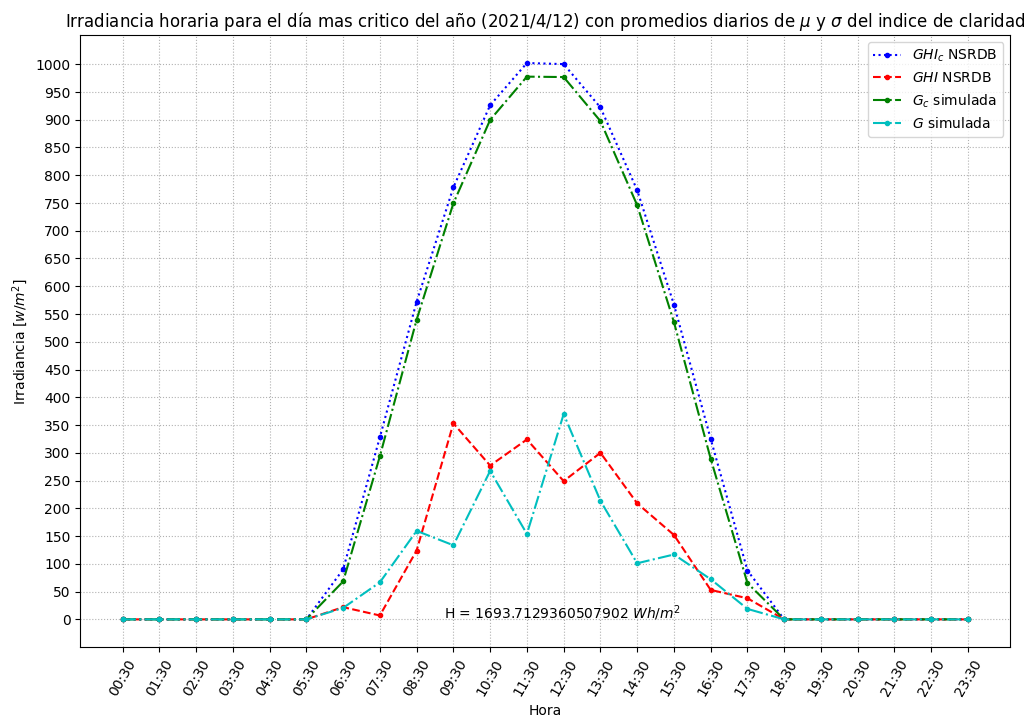

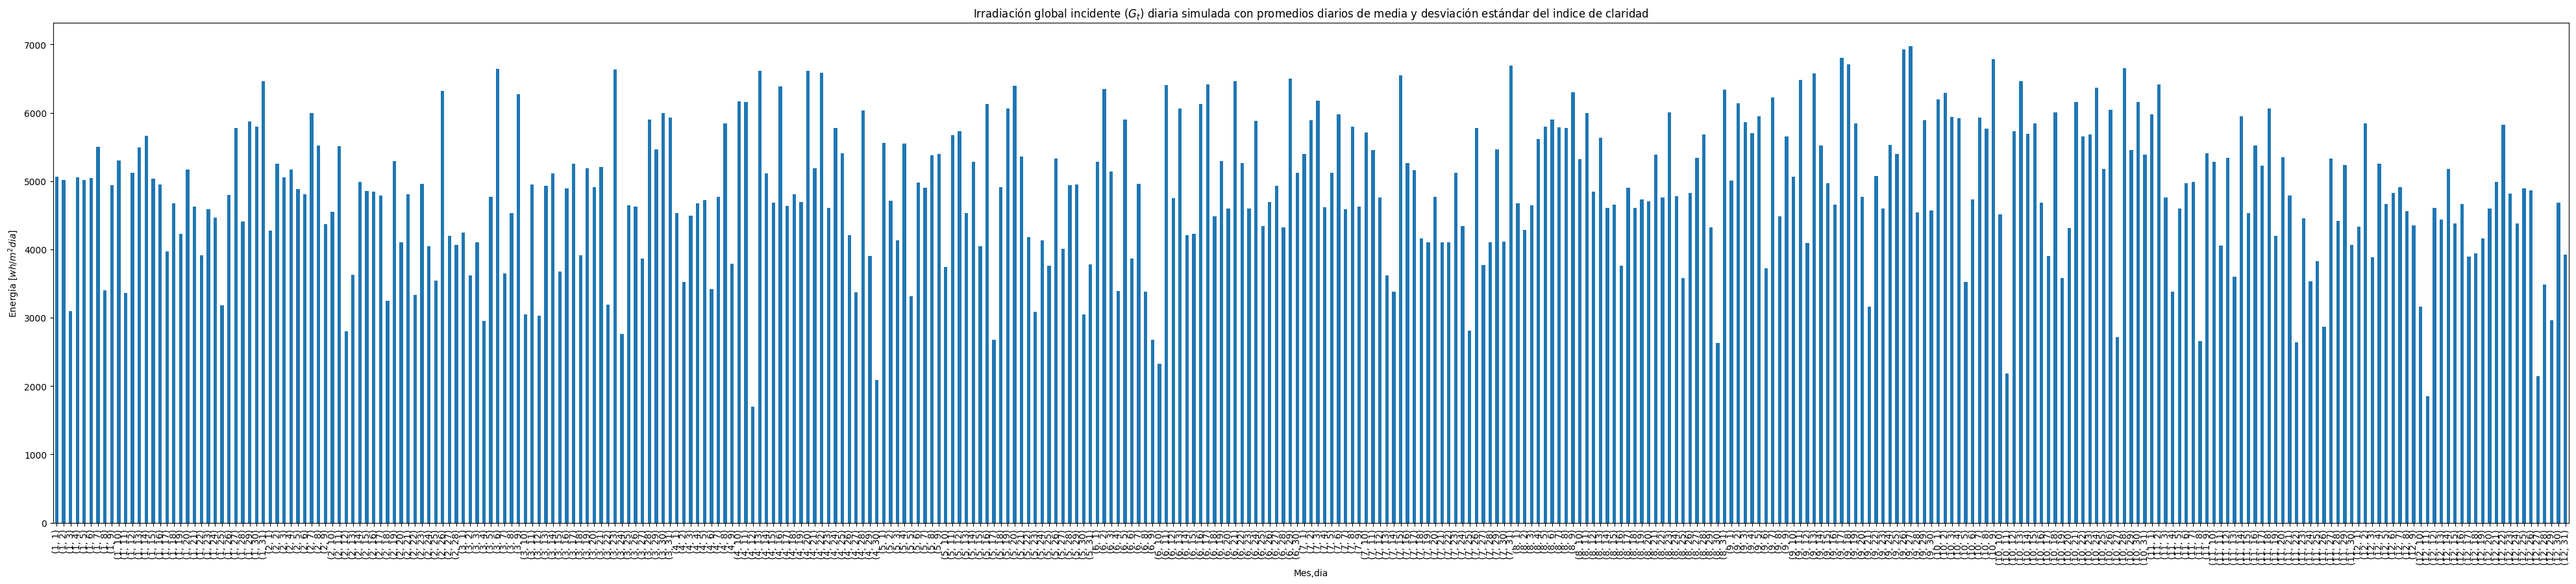

In [3]:
from matplotlib.dates import *

from functions.clear_sky_radiation import *
from functions.sun_position import *
from functions.Incident_irradiance import *
from functions.irrandiance_simulation import *

# Datos del lugar
latitud, longitud = 4.591480, -74.691412
altitud = 321
zona_horaria = -5
# Fecha de simulación
anio = 2021
#
# Configuración del arreglo de paneles
albedo = 0.2
surf_tilt = 0
surf_azm = 180

#-------------------------------------------------------


df_irradiancia['I_sim'], df_irradiancia['I_c'] = daily_irradiance_simulation( irradiance_data=df_irradiancia, time_zone=zona_horaria, latitude=latitud, longitude=longitud, altitude=altitud, climate_type='Tropical', year=2021, surf_azm=surf_azm, surf_tilt=surf_tilt, albedo=albedo )

# Graficando dia con menor irradiación
mes, dia = df_irradiancia.groupby(by=['Month','Day'])['I_sim'].sum().idxmin() 
H_d_min = df_irradiancia.groupby(by=['Month','Day'])['I_sim'].sum().min()
day = df_irradiancia.query(f'Month == {mes} and Day == {dia}')[['Hour','Minute','Clearsky_GHI','GHI','I_c','I_sim']]
day_time = [datetime.time(hour=i.Hour, minute=i.Minute).isoformat('minutes') for i in day.itertuples() ]

fig, ax = subplots( figsize=(12,9) )
fig.autofmt_xdate(rotation=60,ha='center')
ax.set_title(f'Irradiancia horaria para el día mas critico del año ({anio}/{mes}/{dia}) con promedios diarios de $\mu$ y $\sigma$ del indice de claridad')
ax.set_xlabel('Hora')
ax.set_ylabel('Irradiancia $[w/m^2]$')
ax.grid(True, color='#b1b1b1', linestyle=':')
ax.plot( day_time, day['Clearsky_GHI'], 'b.', ls=':', label='$GHI_c$ NSRDB' )
ax.plot( day_time, day['GHI'], 'r.', ls='--', label='$GHI$ NSRDB' )
ax.plot( day_time, day['I_c'], 'g.', ls='-.', label='$G_c$ simulada' )
ax.plot( day_time, day['I_sim'], 'c.', ls='-.', label='$G$ simulada' )
ax.annotate(text=f'H = {H_d_min} $Wh/m^2$ ',xy=(12,1), horizontalalignment='center')
ax.yaxis.set_ticks( list( range( 0, max( df_irradiancia[ 'Clearsky_GHI' ] ), 50 ) ) )
ax.legend()

# # Graficando dias del año
fig2,ax2 = subplots(figsize=(50,10))
df_irradiancia.groupby(by=['Month','Day'])['I_sim'].sum().plot.bar(xlabel='Mes,dia',ylabel='Energía $[wh/m^2 dia]$ ')
ax2.set_title('Irradiación global incidente ($G_t$) diaria simulada con promedios diarios de media y desviación estándar del indice de claridad')


#### Prueba con promedios mensuales de media y desviación estándar del indice de claridad

Text(0.5, 1.0, 'Irradiación global incidente ($G_t$) diaria simulada con promedios mensuales de media y desviación estándar del indice de claridad')

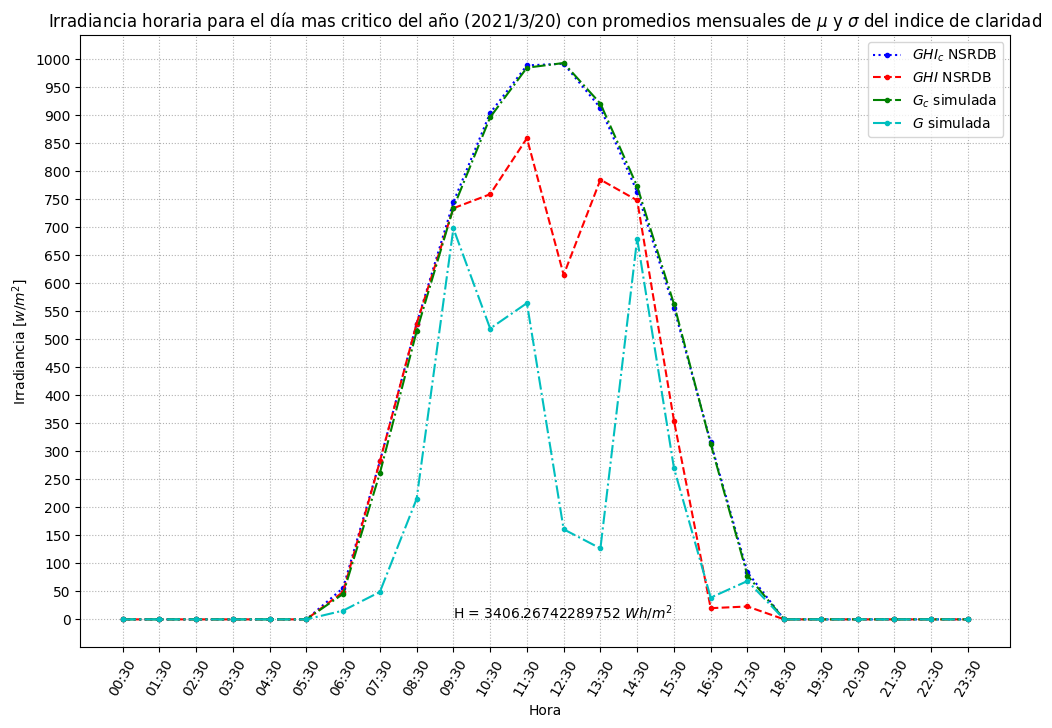

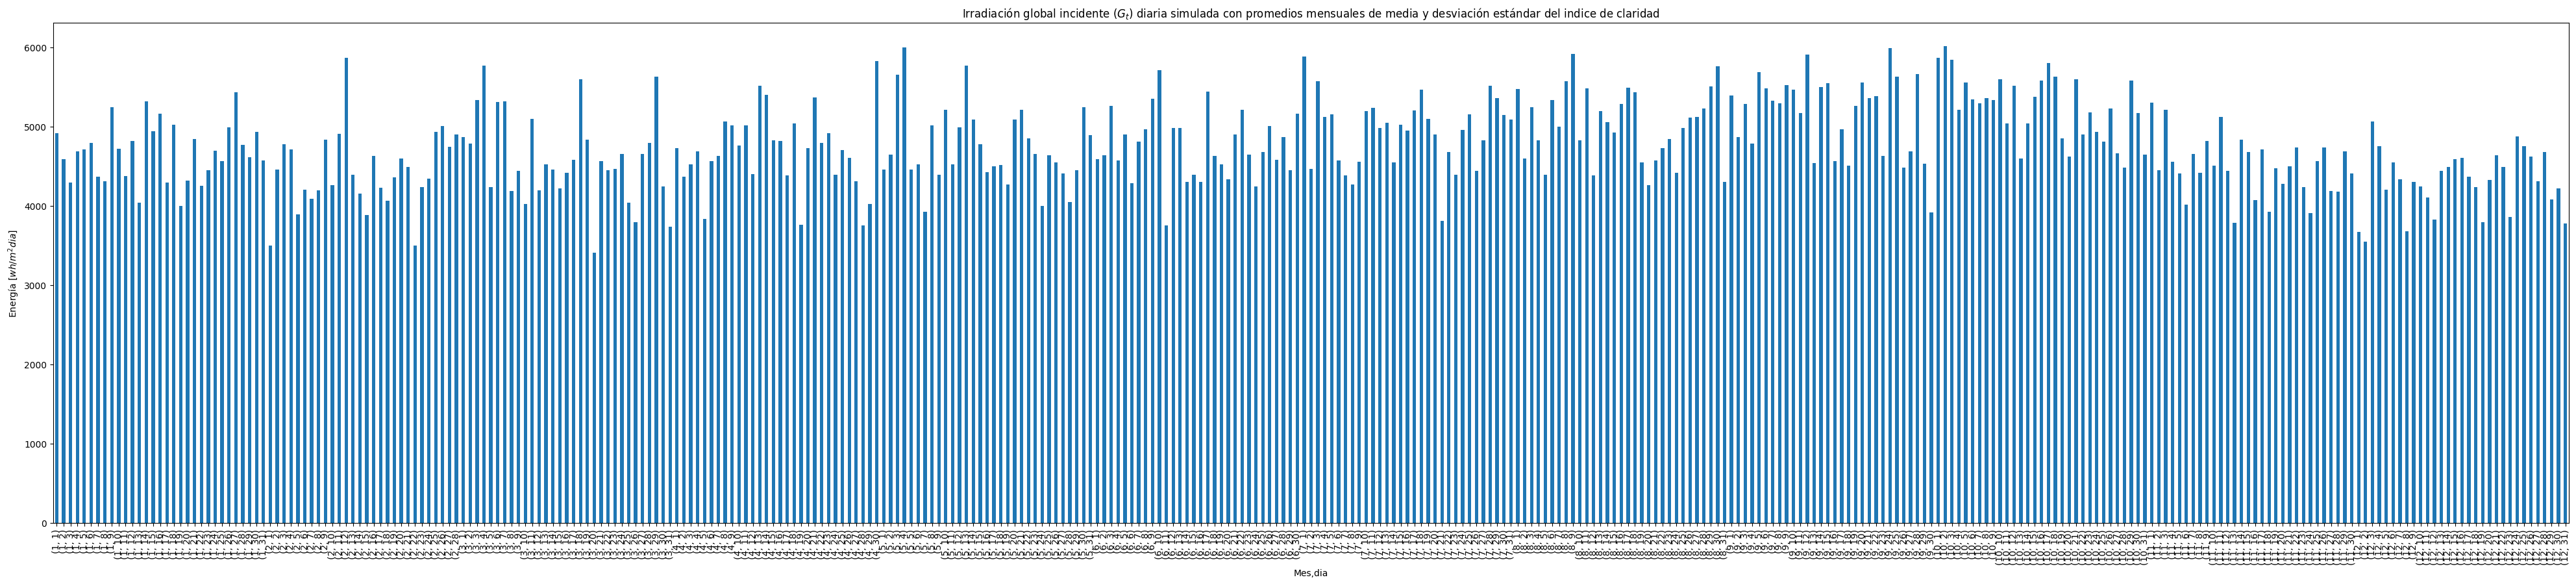

In [4]:

df_irradiancia['I_sim_m'], df_irradiancia['I_c'] = monthly_irradiance_simulation( irradiance_data=df_irradiancia, time_zone=zona_horaria, latitude=latitud, longitude=longitud, altitude=altitud, climate_type='Tropical', year=2021, surf_azm=surf_azm, surf_tilt=surf_tilt, albedo=albedo )

# Graficando dia con menor irradiación
mes, dia = df_irradiancia.groupby(by=['Month','Day'])['I_sim_m'].sum().idxmin() 
H_d_min = df_irradiancia.groupby(by=['Month','Day'])['I_sim_m'].sum().min()
day = df_irradiancia.query(f'Month == {mes} and Day == {dia}')[['Hour','Minute','Clearsky_GHI','GHI','I_c','I_sim_m']]
day_time = [datetime.time(hour=i.Hour, minute=i.Minute).isoformat('minutes') for i in day.itertuples() ]

fig, ax = subplots( figsize=(12,9) )
fig.autofmt_xdate(rotation=60,ha='center')
ax.set_title(f'Irradiancia horaria para el día mas critico del año ({anio}/{mes}/{dia}) con promedios mensuales de $\mu$ y $\sigma$ del indice de claridad')
ax.set_xlabel('Hora')
ax.set_ylabel('Irradiancia $[w/m^2]$')
ax.grid(True, color='#b1b1b1', linestyle=':')
ax.plot( day_time, day['Clearsky_GHI'], 'b.', ls=':', label='$GHI_c$ NSRDB' )
ax.plot( day_time, day['GHI'], 'r.', ls='--', label='$GHI$ NSRDB' )
ax.plot( day_time, day['I_c'], 'g.', ls='-.', label='$G_c$ simulada' )
ax.plot( day_time, day['I_sim_m'], 'c.', ls='-.', label='$G$ simulada' )
ax.yaxis.set_ticks( list( range( 0, max( df_irradiancia[ 'Clearsky_GHI' ] ), 50 ) ) )
ax.annotate(text=f'H = {H_d_min} $Wh/m^2$ ',xy=(12,1), horizontalalignment='center')
ax.legend()

fig2,ax2 = subplots(figsize=(50,10))
df_irradiancia.groupby(by=['Month','Day'])['I_sim_m'].sum().plot.bar( xlabel='Mes,dia',ylabel='Energía $[wh/m^2 dia]$ ' )
ax2.set_title('Irradiación global incidente ($G_t$) diaria simulada con promedios mensuales de media y desviación estándar del indice de claridad')


## Confiabilidad del sistema. Simulación con el método de monteCarlo

Ahora, se debe revisar cual es la combinación de paneles y baterías mas económica, de tal manera que la confiabilidad anual del sistema sea superior al 96% (solamente en 14 de los 365 días del año puede haber eventos con racionamiento).

Para esto en primer lugar se debe generar una función que se encargue de calcular la distribución de confiabilidad dadas **n** condiciones de irradiancia (simulaciones anuales), el perfil de demanda horaria, cantidad y características de paneles y baterías.

Luego es necesario establecer la función costo (función a optimizar). Un modelo sencillo puede considerar el costo de la inversion inicial para el numero de baterías y paneles. También se puede considerar el costo del inversor y el cargador, sin embargo el inversor depende de la carga ( su potencia es independiente de la cantidad de paneles y baterías ) mientras que el cargador si depende de la selección de las baterías.


### Prueba de calculo de racionamiento con una iteración

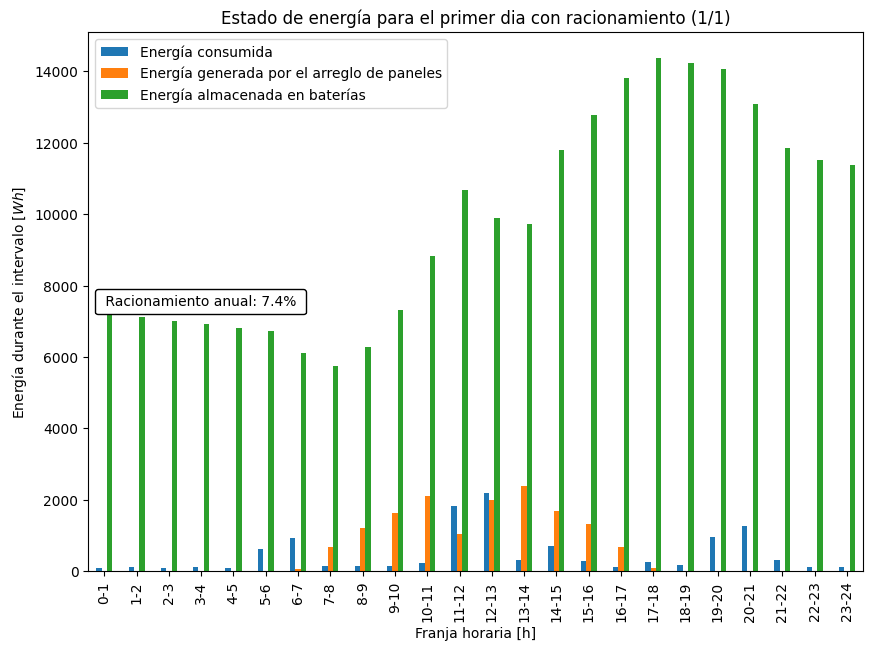

In [7]:
from matplotlib.offsetbox import AnchoredText
from functions.rationing import rationing

# Datos del lugar
latitud, longitud = 4.591480, -74.691412
altitud = 321
zona_horaria = -5
# Fecha de simulación
anio = 2021
# Configuración del arreglo de paneles
albedo = 0.17
surf_tilt = 4
surf_azm = 180

consumo_horario = pd.read_excel('data.xlsx', sheet_name='Edt',index_col='hora')
energia_hora = [ i.energia for i in consumo_horario.itertuples() ]

df_sim = df_irradiancia.loc[:, ('Month','Day','Hour')]

df_sim['I_sim'], df_sim['I_c'] = daily_irradiance_simulation( irradiance_data=df_irradiancia, time_zone=zona_horaria, latitude=latitud, longitude=longitud, altitude=altitud, climate_type='Tropical', year=anio, surf_azm=surf_azm, surf_tilt=surf_tilt, albedo=albedo )
racionamiento, eventos, energia = rationing(I_sim=df_sim, energy_per_hour=energia_hora*365, n_m=7, A_m=2.5, eta_m=19, n_b=4, v_b=12, E_b_max=300, l_b_min=40, l_b_0=50 )
(mes,dia) = eventos[0]

fig, ax = subplots(figsize=(10,7))
energia.query(f'Month == {mes} and Day == {dia} ').loc[:, ('E_c','E_a','E_b')].plot(kind='bar', ax=ax)
ax.legend(["Energía consumida", "Energía generada por el arreglo de paneles","Energía almacenada en baterías"]);
ax.set_title(f'Estado de energía para el primer dia con racionamiento ({mes}/{dia})')
ax.set_xticklabels([f'{h}-{h+1}' for h in range(0,24)])
ax.set_xlabel( 'Franja horaria [h]' )
ax.set_ylabel( 'Energía durante el intervalo $[Wh]$' )
at = AnchoredText(f' Racionamiento anual: {round(racionamiento * 100,2) }% ', prop=dict(size=10), frameon=True, loc='center left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

### Prueba de calculo de racionamiento con el método monte Carlo

In [6]:
from functions.rationing import rationing_monteCarlo

r_mc = rationing_monteCarlo(   iterations=10,
                        irradiance_data=df_irradiancia,
                        time_zone=-5,
                        latitude=4.591480,
                        longitude=-74.691412,
                        altitude=321,
                        climate_type='Tropical',
                        year=2021, 
                        surf_azm=180,
                        surf_tilt=4,
                        albedo=0.17,
                        energy_per_hour=energia_hora,
                        n_m=7,
                        A_m=2.5,
                        eta_m=19,
                        n_b=4,
                        v_b=12,
                        E_b_max=300,
                        l_b_min=40,
                        l_b_0=50
                    )

print('Lista de racionamientos simulados en cada iteración: ', r_mc)
print('máximo racionamiento:',round( max(r_mc) * 100 , 2 ), '%' )
print('media:', round( mean(r_mc) * 100 , 2 ), '%' )
print('desviación estándar:', round( std(r_mc) * 100 , 2 ), '%' )

[0.052054794520547946, 0.057534246575342465, 0.06575342465753424, 0.06575342465753424, 0.04657534246575343, 0.043835616438356165, 0.06575342465753424, 0.052054794520547946, 0.06575342465753424, 0.04657534246575343]
máximo racionamiento: 6.58 %
media: 5.62 %
desviación estándar: 0.86 %
